<a href="https://colab.research.google.com/github/mschoettner/interpret-iqms/blob/main/code/ImageQualitySVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#In order to read the files stored in Google Drive you have to authenticate
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
path = '/content/gdrive/My Drive/Colab Notebooks/'

Mounted at /content/gdrive


some functions to return different types of scoring

In [ ]:
import pandas as pd
import re


def generate_scores(measurements, s_o, bin):
  scores = []
  for _, row in measurements.iterrows():
    scores.append(get_score(scores_df,row['bids_name'], s_o, bin))
  return scores

def get_score(df, value, score_type, is_binary=False):
  if score_type == 'score':
    s = df.loc[df['bids_name'] == value, 'score'].item()
    if is_binary:
      if s == 1:
        return s
      return 0
    return s

  patt = re.compile(r"acq-(.*?)_T1w")
  m = patt.search(value)
  if m:
    s = m.group(1)

    if is_binary:
      if 'headmotion' in s:
        return 0
      return 1
    return s  

  print("Unrecognized movement. returning UNK")
  if is_binary:
    return -1
  return 'UNK'

# Data loading and preprocessing

Load the measurements and scores from the tsv files, and scale the data using min-max scaling

In [ ]:
import pandas as pd
from sklearn import preprocessing


measurements = pd.read_csv(path + "/group_T1w.tsv", sep="\t")
cols = measurements.columns.tolist()
for x in ['bids_name', 'size_x', 'size_y', 'size_z', "spacing_x", "spacing_y", "spacing_z" ]:
  cols.remove(x)

scaler = preprocessing.MinMaxScaler()
#scaler = preprocessing.Normalizer()
d = scaler.fit_transform(measurements[cols])
measurements[cols] = pd.DataFrame(d, columns=cols)

scores_df = pd.read_csv(path + "/scores.tsv", sep="\t")
vectors = []

for _, row in measurements.iterrows():
  vectors.append([row[cols][i] for i in range(len(row[cols]))])


A function for plotting the confusion matrix for an experiment

In [ ]:
from scipy.stats import pearsonr

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


def plot_results(test_y, pred_y, classes, set_up):
  print("set up: {}".format(set_up))

  conf_matrix = confusion_matrix(test_y, pred_y)
  #print("Pearson correlation: {}".format(pearsonr(pred_y, test_y)))

  df_cm = pd.DataFrame(conf_matrix, index = classes,
                    columns = classes)
  plt.figure(figsize = (10,7))
  plt.title(set_up)
  sn.heatmap(df_cm, annot=True)

  print("accuracy: {}".format(accuracy_score(test_y, pred_y)))

A function for running multiple experiments using SVMs with the given kernel (two kernels are used RBF and Linear). The values of C and gamma are varied following a geometric series, according to suggestions found online. 

The parameter values for which the best accuracy and macro-averaged F1 scores value are obtained (for each scoring setting) are saved.

The value of C controls the margin of the hyperplace, and as such, how "permeable" the hyperplane is. A low C means a wider margin around the hyperplane. 

Gamma is important for the RBF kernel only (it doesn't impact the performance of the linear kernel)

In [ ]:
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import numpy as np


def run_experiments(vectors, measurements, svm_kernel):
  min_c = -5
  max_c = 11
  Cs = [2**c for c in range(min_c, max_c)]
  print("Cs: {}".format(Cs))

  min_g = -10
  max_g = 3
  gammas = [2**g for g in range(min_g, max_g)]
  print("gammas: {}".format(gammas))


  score_opt = ['score', 'movement']
  binary = [True, False]

  acc = {}
  f1 = {}

  maxes = {"acc": {}, "f1": {}}
  scores = {}

  N = len(vectors)
  N_train = int(0.9 * N)

  for s_o in score_opt:
    acc[s_o] = {}
    f1[s_o] = {}
    scores[s_o] = {}

    maxes["acc"][s_o] = {}
    maxes["f1"][s_o] = {}


    for bin in binary:

      is_bin = "false"
      if bin:
        is_bin = "true"

      scores[s_o][is_bin] = generate_scores(measurements, s_o, bin)

      acc[s_o][is_bin] = []
      f1[s_o][is_bin] = []

      maxes["acc"][s_o][is_bin] = {}
      maxes["f1"][s_o][is_bin] = {}

      print("Processing scoring {}, binary={}".format(s_o, is_bin))

      max_acc = 0
      max_acc_C = 0
      max_acc_gamma = 0

      max_f1 = 0
      max_f1_C = 0
      max_f1_gamma = 0

      train_x = vectors[0:N_train]
      train_y = scores[s_o][is_bin][0:N_train]

      test_x = vectors[N_train:]
      test_y = scores[s_o][is_bin][N_train:]

      for C in Cs:
        for gamma in gammas:
          #classif_n = svm.SVC(kernel='poly')
          classif_n = svm.SVC(kernel=svm_kernel, C=C, gamma=gamma)
          #classif_n = svm.SVR()
          classif_n.fit(train_x, train_y)
          pred_y = classif_n.predict(test_x)

          acc_x = accuracy_score(test_y, pred_y)
          f1_x = f1_score(test_y, pred_y, average='macro')

          acc[s_o][is_bin].append(acc_x)
          f1[s_o][is_bin].append(f1_x)

          if acc_x > max_acc:
            max_acc = acc_x
            max_acc_C = C
            max_acc_gamma = gamma

          if f1_x > max_f1:
            max_f1 = f1_x
            max_f1_C = C
            max_f1_gamma = gamma

      maxes["acc"][s_o][is_bin] = {"max": max_acc, "C": max_acc_C, "gamma": max_acc_gamma}
      maxes["f1"][s_o][is_bin] = {"max": max_f1, "C": max_f1_C, "gamma": max_f1_gamma}

      #plot_results(test_y, pred_y, list(set(scores)), s_o + " binary=" + is_bin)

  print("\n\nMax values for all settings for SVM with kernel {}".format(svm_kernel))
  for m in maxes:
    for s_o in maxes[m]:
      for is_bin in maxes[m][s_o]:
        print("scoring = {} / is_bin = {} ==> {} = {}; C = {}; gamma = {}".format(s_o, is_bin, m, maxes[m][s_o][is_bin]["max"], maxes[m][s_o][is_bin]["C"], maxes[m][s_o][is_bin]["gamma"]))

  return scores, acc, f1, maxes, Cs, gammas


Some functions for plotting

In [ ]:
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np


def get_coords(values, Cs, gammas):
  X = []
  Y = []
  Z = np.zeros((len(Cs), len(gammas)))

  for i in range(len(Cs)):
    for j in range(len(gammas)):
      X.append(Cs[i])
      Y.append(gammas[j])
      Z[i][j] = values[i*len(gammas) + j]

#  return X, Y, Z
  X, Y = np.meshgrid(gammas, Cs) 
  return X, Y, Z


def plot_params(accs, f1s, Cs, gammas, title):

  fig = plt.figure(figsize=(18, 6))
  ax_acc = fig.add_subplot(121, projection='3d')

  X, Y, Z = get_coords(accs, Cs, gammas)

  ax_acc.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
  ax_acc.set_title("accuracy")
  ax_acc.set_xlabel("gamma")
  ax_acc.set_ylabel("C")
  ax_acc.set_zlabel("acc")

  ax_f1 = fig.add_subplot(122, projection='3d')

  X, Y, Z = get_coords(accs, Cs, gammas)

  ax_f1.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
  ax_f1.set_title("f1 score")
  ax_f1.set_xlabel("gamma")
  ax_f1.set_ylabel("C")
  ax_f1.set_zlabel("f1")

  plt.title(title)
  plt.show()

def plot_all_params(acc, f1, Cs, gammas):
  for s_o in acc:
    for is_bin in acc[s_o]:
      plot_params(acc[s_o][is_bin], f1[s_o][is_bin], Cs, gammas, s_o + " binary=" + is_bin)

def plot_maxes(maxes, N_train, kernel):

  for m in maxes:
    for s_o in maxes[m]:
      for is_bin in maxes[m][s_o]:
        C = maxes[m][s_o][is_bin]["C"]
        gamma = maxes[m][s_o][is_bin]["gamma"]

        train_x = vectors[0:N_train]
        train_y = scores[s_o][is_bin][0:N_train]

        test_x = vectors[N_train:]
        test_y = scores[s_o][is_bin][N_train:]

        classif = svm.SVC(kernel=kernel, C=C, gamma=gamma)
        classif.fit(train_x, train_y)
        pred_y = classif.predict(test_x)

        acc = accuracy_score(test_y, pred_y)
        f1 = f1_score(test_y, pred_y, average='macro')

        print("Accuracy = {}, macro F1 = {}".format(acc, f1))
        plot_results(test_y, pred_y, list(set(scores[s_o][is_bin])), s_o + " binary=" + is_bin + "   acc=" + str(acc) + " macro f1=" + str(f1))



# Experiments

Runs experiments with SVMs for two kernels (RBF, Linear), for different scoring options (a.k.a classes), and finds the best C and gamma setting from the given possibilities. 

Plots the surfaces determined by the different C and gamma combinations.

Plots the confusion matrices for the best results.



Experimenting with rbf kernel
Cs: [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
gammas: [0.0009765625, 0.001953125, 0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4]
Processing scoring score, binary=true
Processing scoring score, binary=false
Processing scoring movement, binary=true
Processing scoring movement, binary=false


Max values for all settings for SVM with kernel rbf
scoring = score / is_bin = true ==> acc = 0.9772727272727273; C = 0.0625; gamma = 0.25
scoring = score / is_bin = false ==> acc = 0.9090909090909091; C = 8; gamma = 0.03125
scoring = movement / is_bin = true ==> acc = 1.0; C = 0.125; gamma = 1
scoring = movement / is_bin = false ==> acc = 0.9090909090909091; C = 32; gamma = 0.25
scoring = score / is_bin = true ==> f1 = 0.9732847601700061; C = 0.0625; gamma = 0.25
scoring = score / is_bin = false ==> f1 = 0.8980405559352928; C = 8; gamma = 0.03125
scoring = movement / is_bin = true ==> f1 = 1.0; C = 0

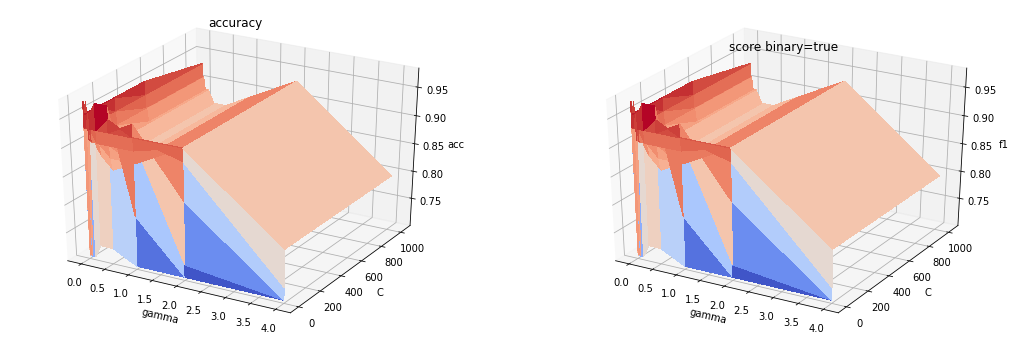

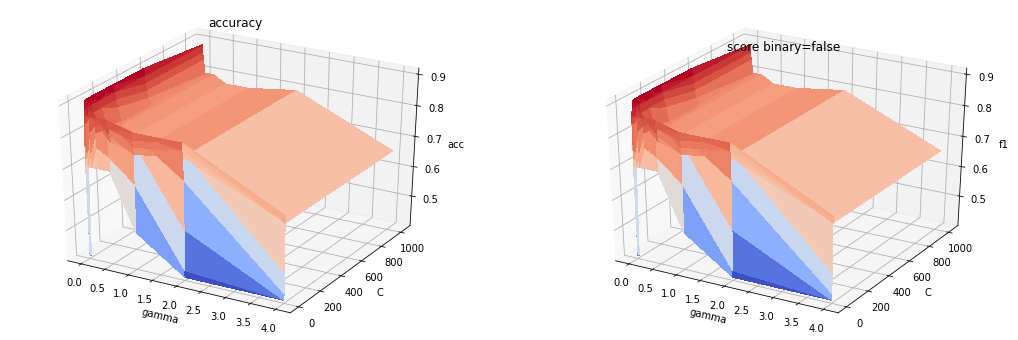

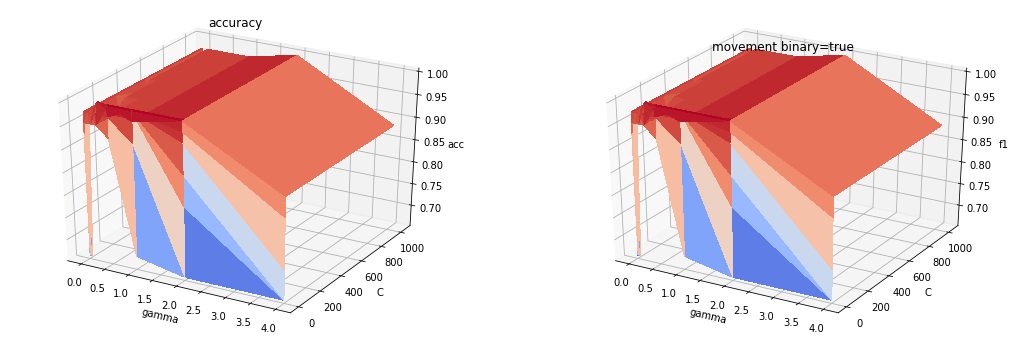

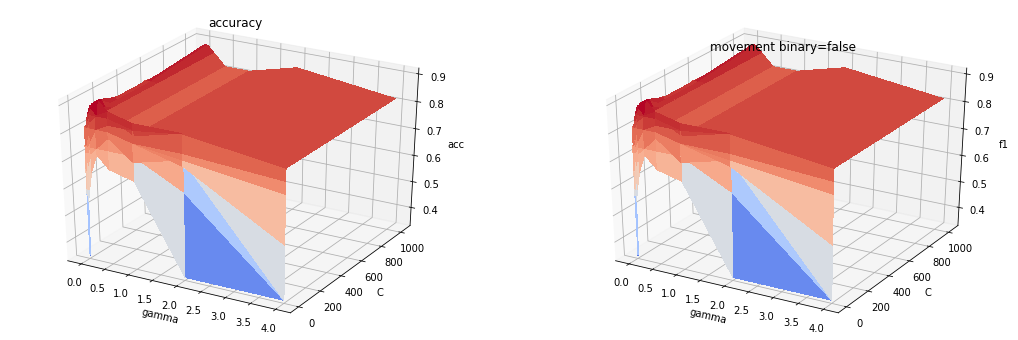



Max acc and f1 analysis
Accuracy = 0.9772727272727273, macro F1 = 0.9732847601700061
set up: score binary=true   acc=0.9772727272727273 macro f1=0.9732847601700061
accuracy: 0.9772727272727273
Accuracy = 0.9090909090909091, macro F1 = 0.8980405559352928
set up: score binary=false   acc=0.9090909090909091 macro f1=0.8980405559352928
accuracy: 0.9090909090909091
Accuracy = 1.0, macro F1 = 1.0
set up: movement binary=true   acc=1.0 macro f1=1.0
accuracy: 1.0
Accuracy = 0.9090909090909091, macro F1 = 0.9057071960297766
set up: movement binary=false   acc=0.9090909090909091 macro f1=0.9057071960297766
accuracy: 0.9090909090909091
Accuracy = 0.9772727272727273, macro F1 = 0.9732847601700061
set up: score binary=true   acc=0.9772727272727273 macro f1=0.9732847601700061
accuracy: 0.9772727272727273
Accuracy = 0.9090909090909091, macro F1 = 0.8980405559352928
set up: score binary=false   acc=0.9090909090909091 macro f1=0.8980405559352928
accuracy: 0.9090909090909091
Accuracy = 1.0, macro F1 =

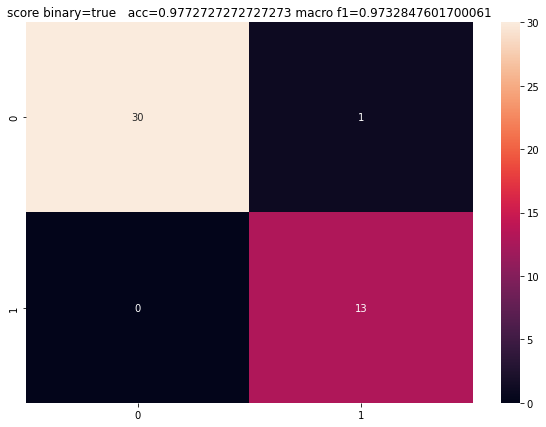

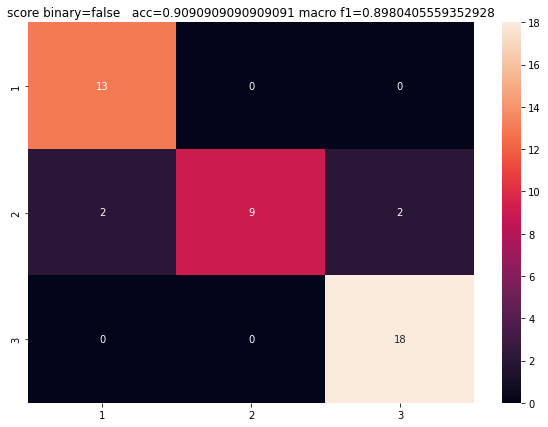

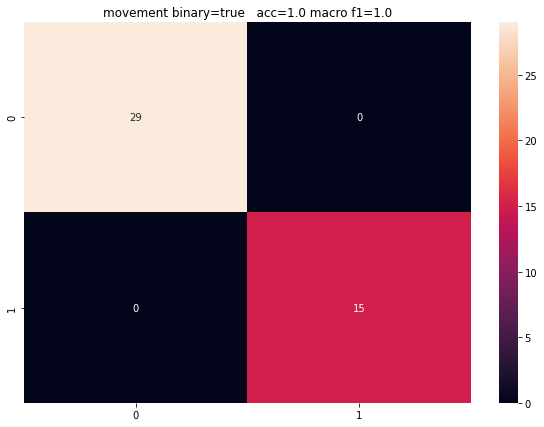

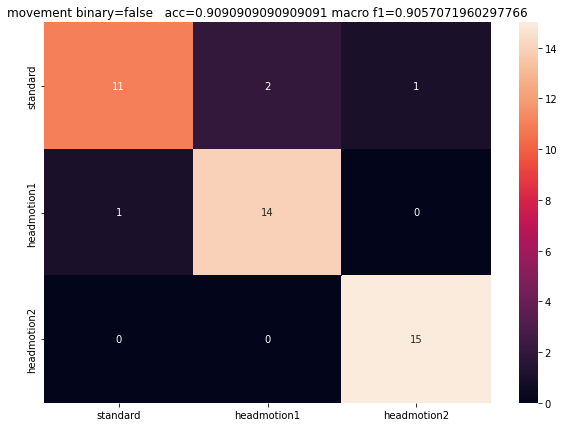

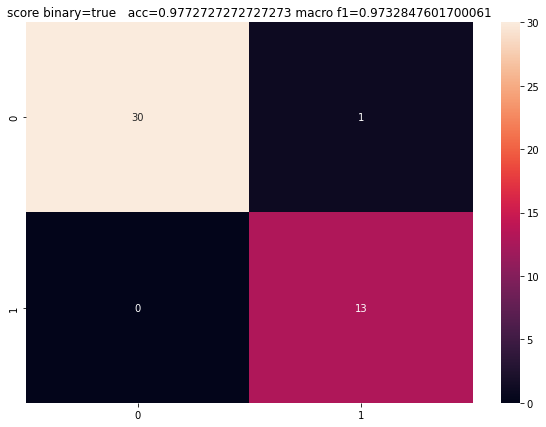

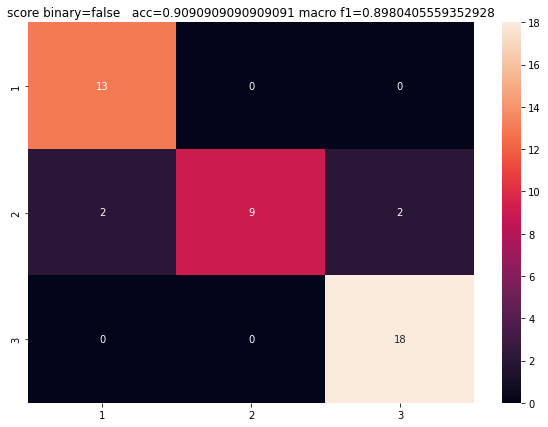

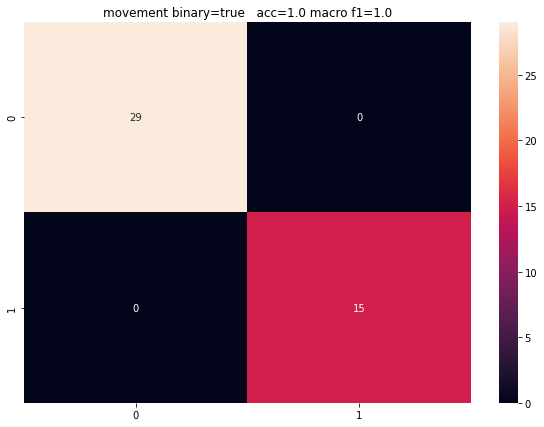

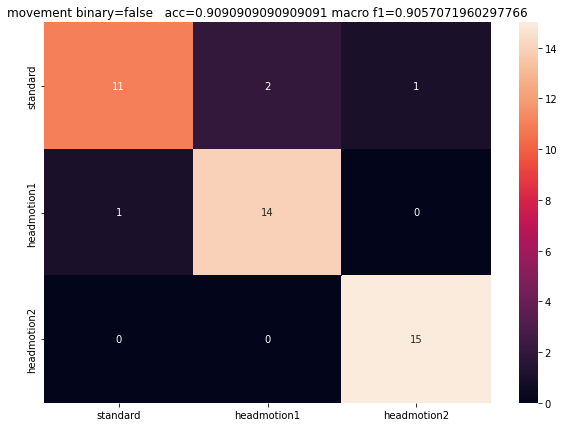

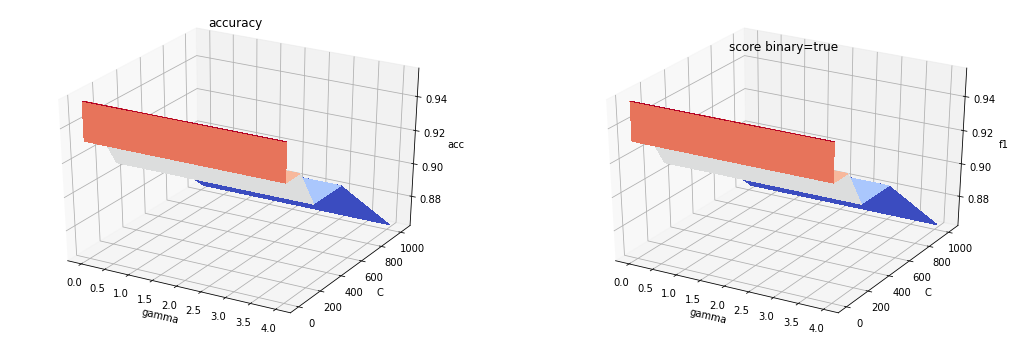

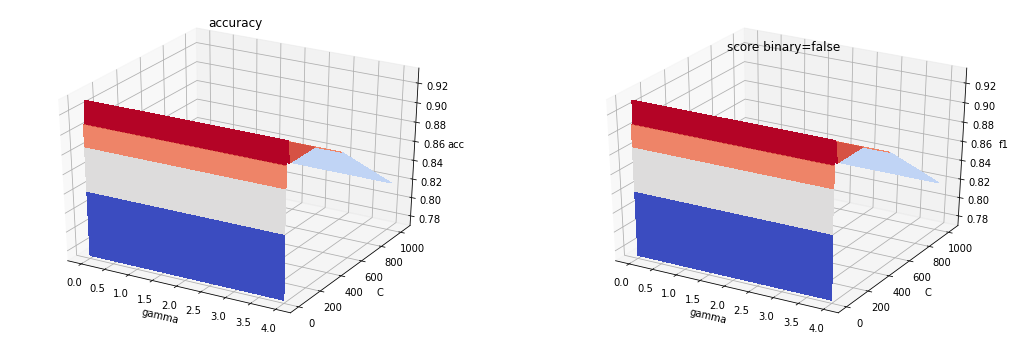

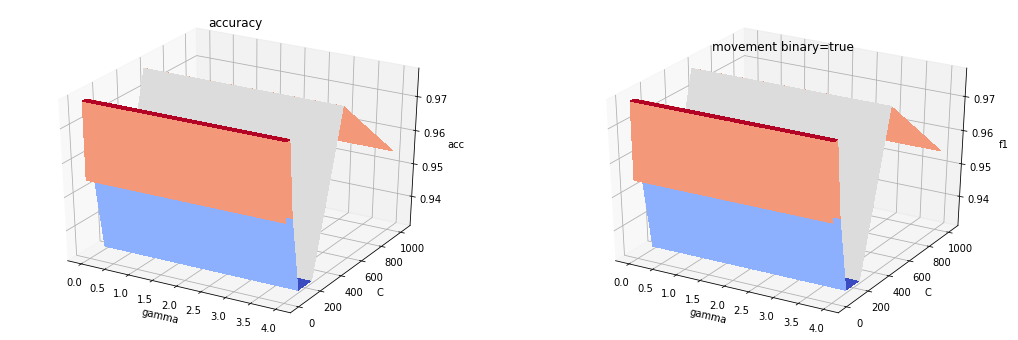

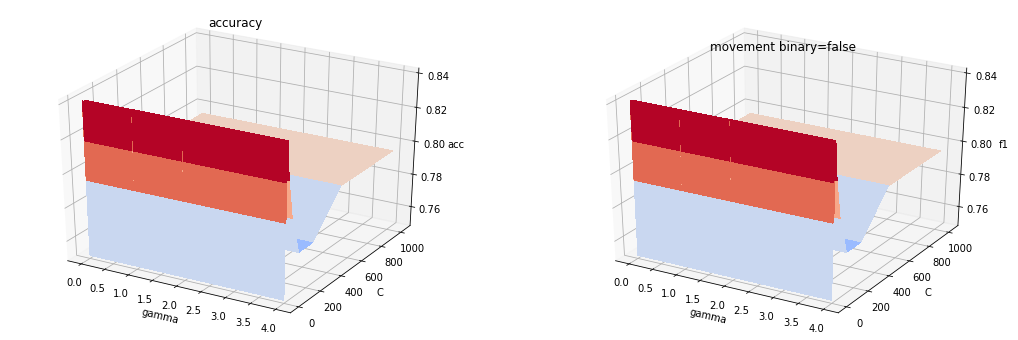



Max acc and f1 analysis
Accuracy = 0.9545454545454546, macro F1 = 0.9476190476190476
set up: score binary=true   acc=0.9545454545454546 macro f1=0.9476190476190476
accuracy: 0.9545454545454546
Accuracy = 0.9318181818181818, macro F1 = 0.9220389805097451
set up: score binary=false   acc=0.9318181818181818 macro f1=0.9220389805097451
accuracy: 0.9318181818181818
Accuracy = 0.9772727272727273, macro F1 = 0.9750990379173741
set up: movement binary=true   acc=0.9772727272727273 macro f1=0.9750990379173741
accuracy: 0.9772727272727273
Accuracy = 0.8409090909090909, macro F1 = 0.8390804597701149
set up: movement binary=false   acc=0.8409090909090909 macro f1=0.8390804597701149
accuracy: 0.8409090909090909
Accuracy = 0.9545454545454546, macro F1 = 0.9476190476190476
set up: score binary=true   acc=0.9545454545454546 macro f1=0.9476190476190476
accuracy: 0.9545454545454546
Accuracy = 0.9318181818181818, macro F1 = 0.9220389805097451
set up: score binary=false   acc=0.9318181818181818 macro f1

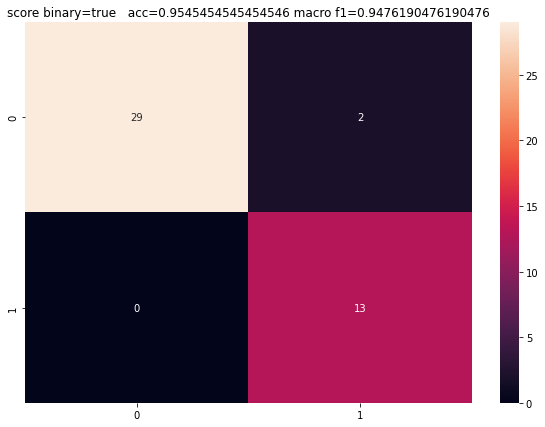

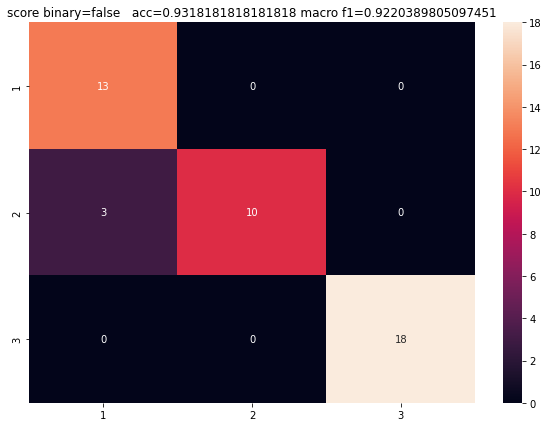

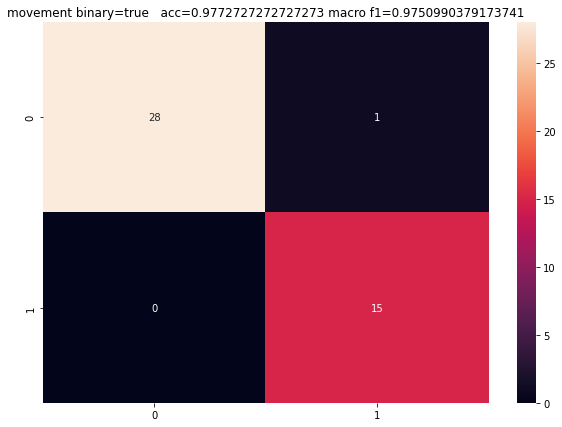

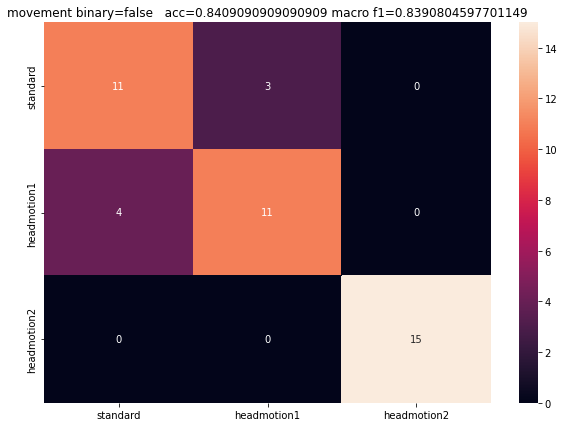

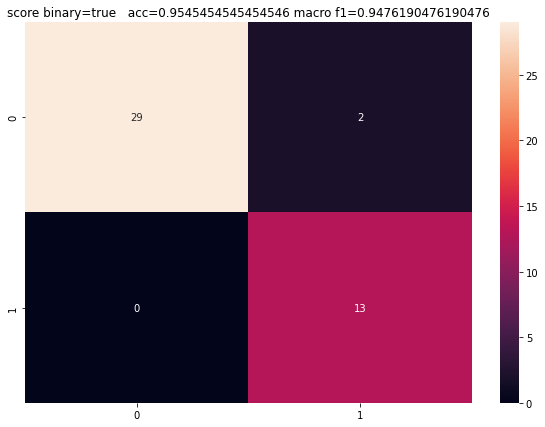

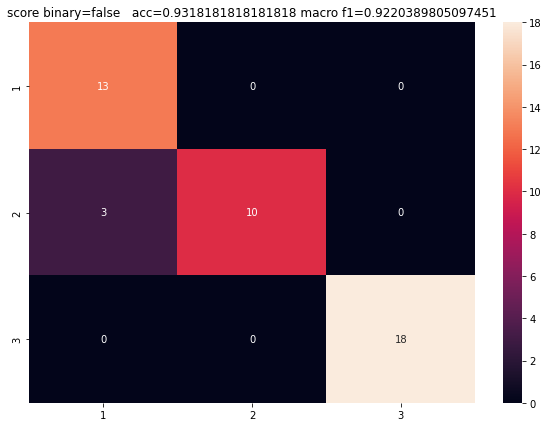

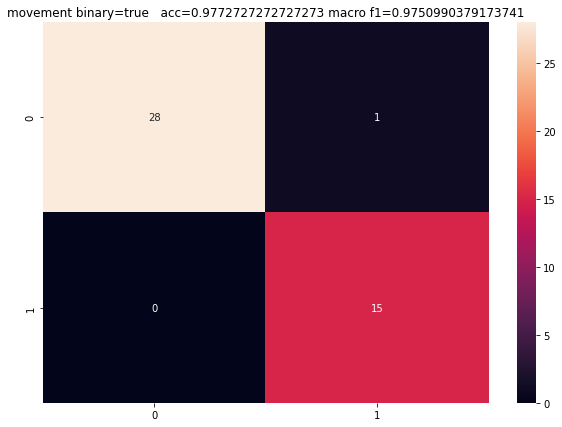

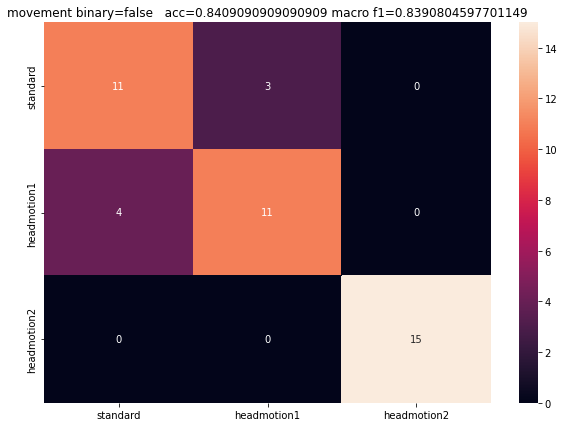

In [ ]:
kernels = ['rbf', 'linear']
N = len(vectors)
N_train = int(0.9 * N)

maxes = {}

for kernel in kernels:
  print("\n\nExperimenting with {} kernel".format(kernel))
  scores, acc, f1, maxes[kernel], Cs, gammas = run_experiments(vectors, measurements, kernel)

  print("\n\nPlotting the C vs gamma analysis")
  plot_all_params(acc, f1, Cs, gammas)

  print("\n\nMax acc and f1 analysis")
  plot_maxes(maxes[kernel], N_train, kernel)


Functions for plotting the feature coefficients.

In [ ]:
def plot_binary_features(coefs, feats, s_o, is_bin, C, gamma):
  coefs, feats = map(list, zip(*sorted(zip(coefs, feats), reverse=True)))  
  print("\nexperiment: classes = {}, binary={}, C={}, gamma={}".format(s_o, is_bin, C, gamma))
  print("acc = {}; macro f1 = {}".format(acc, f1))
  print("\nfeatures ordered by their coeficient (higher first):\n{}".format(feats))    

  figure(figsize=(14,6))
  plt.bar(feats, coefs)
  feature_names = np.array(feats)
  plt.xticks(np.arange(1, 1 + len(feats)), feature_names, rotation=60, ha='right')
  plt.show()


def get_indices(classes):
  ord_1 = ["standard", "headmotion1", "headmotion2"]
  ord_2 = [1, 2, 3]

  if "standard" in classes:
    return [classes.index(i) for i in ord_1]

  return [classes.index(i) for i in ord_2]



def plot_multiclass_features(coefs, feats, s_o, is_bin, C, gamma, classes):

  colours = ['indianred', 'gray', 'black']
  indices = get_indices(classes)

  coefs_1, coefs_2, coefs_3, feats = map(list, zip(*sorted(zip(coefs[indices[0]], coefs[indices[1]], coefs[indices[2]], feats), reverse=True)))  
  print("\nexperiment: classes = {}, binary={}, C={}, gamma={}".format(s_o, is_bin, C, gamma))
  print("acc = {}; macro f1 = {}".format(acc, f1))
  print("\nfeatures ordered by their coeficient (higher first):\n{}".format(feats))    

  figure(figsize=(14,6))
  plt.bar(feats, coefs_1, alpha=0.5, color=colours[0], label=classes[indices[0]])
  plt.bar(feats, coefs_2, alpha=0.5, color=colours[1], label=classes[indices[1]])
  plt.bar(feats, coefs_3, alpha=0.5, color=colours[2], label=classes[indices[2]])
  feature_names = np.array(feats)
  plt.xticks(np.arange(1, 1 + len(feats)), feature_names, rotation=60, ha='right')
  plt.legend()
  plt.show()



# Analysis of the feature coefficients

For the SVM with a linear kernel, we can get feature coefficients that give us information about how "good" the feature is for classification. The higher the coefficient, the closer the hyperplane is to be orthogonal  

Multi-class classification is transformed into N binary classification problems. In that case the features for classifying each class are plotted, and ordered by the "actual" positive class (i.e. score = 1, or movement = 'standard')


experiment: classes = score, binary=true, C=0.0625, gamma=0.0009765625
acc = 0.9545454545454546; macro f1 = 0.9476190476190476

features ordered by their coeficient (higher first):
['snrd_gm', 'snrd_wm', 'snrd_total', 'snr_wm', 'snrd_csf', 'snr_total', 'summary_gm_n', 'summary_wm_p05', 'cnr', 'rpve_wm', 'icvs_gm', 'summary_gm_p95', 'tpm_overlap_csf', 'qi_1', 'fber', 'summary_gm_mean', 'summary_gm_median', 'summary_bg_n', 'tpm_overlap_gm', 'summary_bg_k', 'summary_gm_p05', 'icvs_csf', 'fwhm_x', 'qi_2', 'tpm_overlap_wm', 'rpve_gm', 'summary_csf_k', 'summary_gm_mad', 'summary_gm_stdv', 'snr_gm', 'fwhm_z', 'summary_bg_p05', 'rpve_csf', 'summary_gm_k', 'summary_csf_n', 'fwhm_avg', 'summary_csf_stdv', 'summary_bg_median', 'summary_bg_mad', 'efc', 'summary_wm_k', 'summary_csf_mad', 'summary_wm_median', 'wm2max', 'summary_csf_p05', 'summary_bg_mean', 'summary_csf_p95', 'fwhm_y', 'summary_wm_n', 'summary_bg_p95', 'snr_csf', 'summary_csf_median', 'summary_csf_mean', 'summary_bg_stdv', 'inu_rang

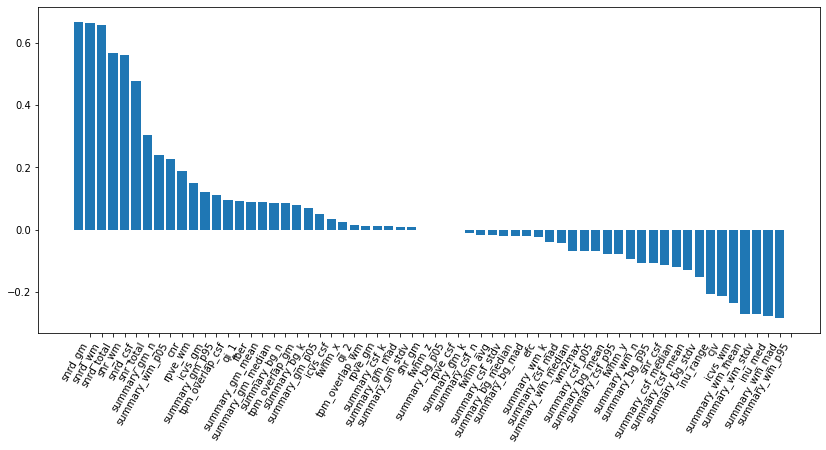


experiment: classes = score, binary=false, C=16, gamma=0.0009765625
acc = 0.9318181818181818; macro f1 = 0.9220389805097451

features ordered by their coeficient (higher first):
['icvs_gm', 'tpm_overlap_csf', 'summary_wm_median', 'summary_gm_p95', 'efc', 'summary_gm_stdv', 'rpve_wm', 'cnr', 'snr_wm', 'summary_csf_stdv', 'snrd_csf', 'rpve_csf', 'snr_csf', 'fber', 'summary_gm_mad', 'summary_bg_mad', 'summary_bg_median', 'snr_total', 'snrd_total', 'summary_bg_k', 'summary_csf_p05', 'snrd_gm', 'snrd_wm', 'rpve_gm', 'fwhm_x', 'summary_csf_mean', 'qi_2', 'summary_bg_n', 'summary_gm_k', 'summary_bg_p95', 'tpm_overlap_wm', 'summary_wm_p05', 'summary_wm_n', 'summary_bg_p05', 'summary_csf_n', 'qi_1', 'summary_bg_mean', 'summary_gm_p05', 'fwhm_z', 'summary_gm_mean', 'summary_csf_p95', 'inu_range', 'fwhm_avg', 'summary_csf_mad', 'summary_gm_n', 'icvs_csf', 'summary_bg_stdv', 'summary_gm_median', 'summary_wm_k', 'summary_csf_median', 'tpm_overlap_gm', 'wm2max', 'summary_wm_stdv', 'icvs_wm', 'fwhm_

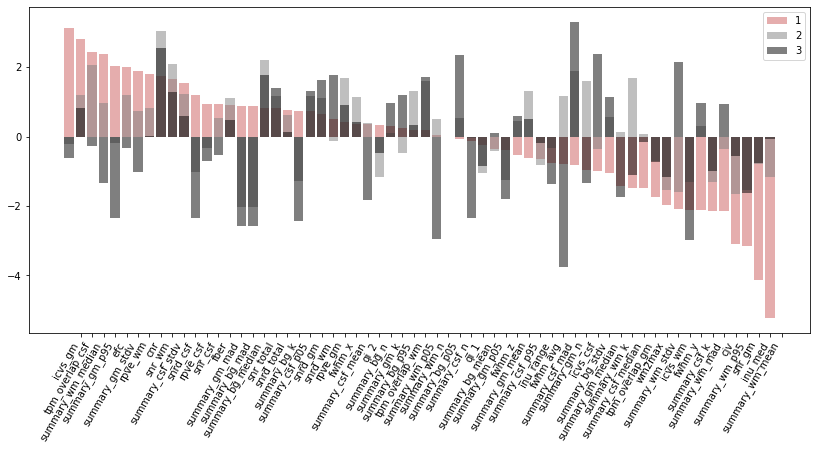


experiment: classes = movement, binary=true, C=0.0625, gamma=0.0009765625
acc = 0.9772727272727273; macro f1 = 0.9750990379173741

features ordered by their coeficient (higher first):
['snrd_gm', 'snrd_wm', 'snrd_total', 'snr_wm', 'snrd_csf', 'snr_total', 'summary_gm_n', 'summary_wm_p05', 'rpve_wm', 'summary_gm_p95', 'cnr', 'summary_gm_median', 'summary_gm_mean', 'summary_bg_k', 'summary_bg_n', 'icvs_gm', 'summary_gm_p05', 'summary_csf_k', 'qi_1', 'snr_gm', 'icvs_csf', 'summary_gm_k', 'fwhm_x', 'tpm_overlap_gm', 'rpve_gm', 'fwhm_avg', 'fwhm_z', 'qi_2', 'summary_csf_n', 'summary_csf_stdv', 'fwhm_y', 'efc', 'rpve_csf', 'summary_bg_p05', 'summary_bg_mad', 'summary_bg_median', 'summary_wm_k', 'summary_csf_mad', 'summary_gm_stdv', 'fber', 'summary_gm_mad', 'summary_csf_p95', 'summary_csf_p05', 'summary_bg_mean', 'tpm_overlap_wm', 'tpm_overlap_csf', 'summary_csf_mean', 'summary_csf_median', 'inu_range', 'summary_bg_p95', 'snr_csf', 'summary_bg_stdv', 'summary_wm_n', 'summary_wm_median', 'cj

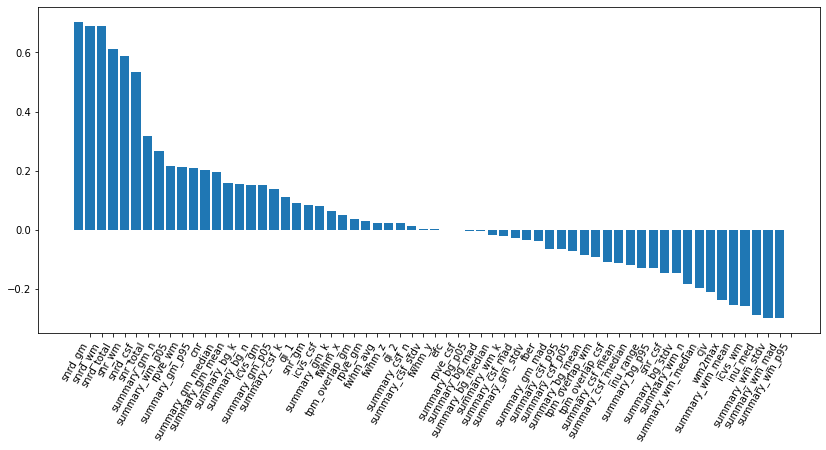


experiment: classes = movement, binary=false, C=0.5, gamma=0.0009765625
acc = 0.8409090909090909; macro f1 = 0.8390804597701149

features ordered by their coeficient (higher first):
['summary_wm_k', 'summary_wm_p95', 'wm2max', 'summary_wm_stdv', 'summary_wm_mad', 'tpm_overlap_wm', 'summary_wm_mean', 'icvs_wm', 'summary_wm_n', 'inu_med', 'summary_gm_stdv', 'snr_csf', 'cjv', 'summary_wm_median', 'summary_gm_mad', 'summary_gm_k', 'tpm_overlap_csf', 'summary_csf_median', 'summary_bg_stdv', 'summary_bg_p95', 'summary_csf_mean', 'tpm_overlap_gm', 'summary_bg_mean', 'inu_range', 'summary_csf_p95', 'summary_csf_p05', 'rpve_csf', 'summary_bg_p05', 'qi_1', 'rpve_gm', 'fwhm_z', 'summary_csf_mad', 'fwhm_x', 'summary_gm_p95', 'summary_csf_n', 'summary_csf_stdv', 'summary_bg_median', 'summary_bg_mad', 'fber', 'fwhm_avg', 'icvs_csf', 'qi_2', 'summary_bg_n', 'icvs_gm', 'summary_gm_median', 'summary_gm_mean', 'fwhm_y', 'rpve_wm', 'efc', 'summary_gm_p05', 'summary_csf_k', 'summary_wm_p05', 'summary_gm_

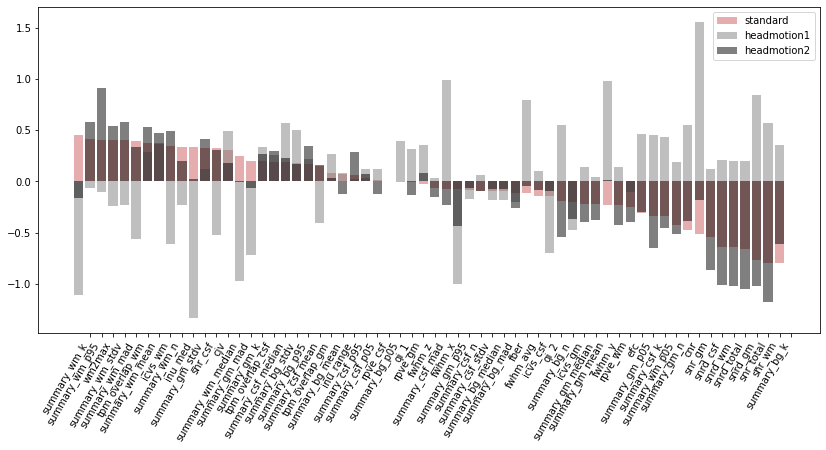


experiment: classes = score, binary=true, C=0.0625, gamma=0.0009765625
acc = 0.9545454545454546; macro f1 = 0.9476190476190476

features ordered by their coeficient (higher first):
['snrd_gm', 'snrd_wm', 'snrd_total', 'snr_wm', 'snrd_csf', 'snr_total', 'summary_gm_n', 'summary_wm_p05', 'cnr', 'rpve_wm', 'icvs_gm', 'summary_gm_p95', 'tpm_overlap_csf', 'qi_1', 'fber', 'summary_gm_mean', 'summary_gm_median', 'summary_bg_n', 'tpm_overlap_gm', 'summary_bg_k', 'summary_gm_p05', 'icvs_csf', 'fwhm_x', 'qi_2', 'tpm_overlap_wm', 'rpve_gm', 'summary_csf_k', 'summary_gm_mad', 'summary_gm_stdv', 'snr_gm', 'fwhm_z', 'summary_bg_p05', 'rpve_csf', 'summary_gm_k', 'summary_csf_n', 'fwhm_avg', 'summary_csf_stdv', 'summary_bg_median', 'summary_bg_mad', 'efc', 'summary_wm_k', 'summary_csf_mad', 'summary_wm_median', 'wm2max', 'summary_csf_p05', 'summary_bg_mean', 'summary_csf_p95', 'fwhm_y', 'summary_wm_n', 'summary_bg_p95', 'snr_csf', 'summary_csf_median', 'summary_csf_mean', 'summary_bg_stdv', 'inu_rang

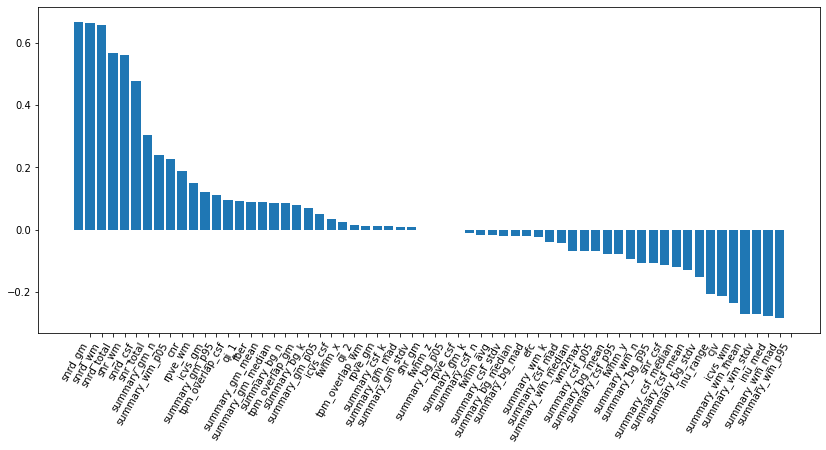


experiment: classes = score, binary=false, C=16, gamma=0.0009765625
acc = 0.9318181818181818; macro f1 = 0.9220389805097451

features ordered by their coeficient (higher first):
['icvs_gm', 'tpm_overlap_csf', 'summary_wm_median', 'summary_gm_p95', 'efc', 'summary_gm_stdv', 'rpve_wm', 'cnr', 'snr_wm', 'summary_csf_stdv', 'snrd_csf', 'rpve_csf', 'snr_csf', 'fber', 'summary_gm_mad', 'summary_bg_mad', 'summary_bg_median', 'snr_total', 'snrd_total', 'summary_bg_k', 'summary_csf_p05', 'snrd_gm', 'snrd_wm', 'rpve_gm', 'fwhm_x', 'summary_csf_mean', 'qi_2', 'summary_bg_n', 'summary_gm_k', 'summary_bg_p95', 'tpm_overlap_wm', 'summary_wm_p05', 'summary_wm_n', 'summary_bg_p05', 'summary_csf_n', 'qi_1', 'summary_bg_mean', 'summary_gm_p05', 'fwhm_z', 'summary_gm_mean', 'summary_csf_p95', 'inu_range', 'fwhm_avg', 'summary_csf_mad', 'summary_gm_n', 'icvs_csf', 'summary_bg_stdv', 'summary_gm_median', 'summary_wm_k', 'summary_csf_median', 'tpm_overlap_gm', 'wm2max', 'summary_wm_stdv', 'icvs_wm', 'fwhm_

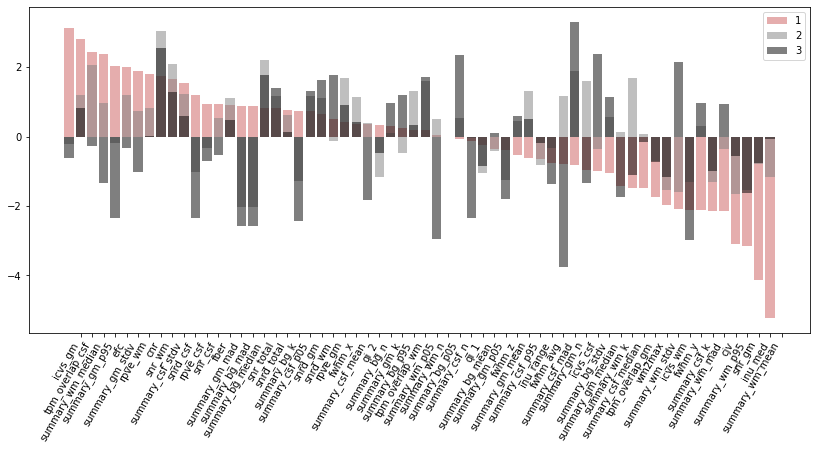


experiment: classes = movement, binary=true, C=0.0625, gamma=0.0009765625
acc = 0.9772727272727273; macro f1 = 0.9750990379173741

features ordered by their coeficient (higher first):
['snrd_gm', 'snrd_wm', 'snrd_total', 'snr_wm', 'snrd_csf', 'snr_total', 'summary_gm_n', 'summary_wm_p05', 'rpve_wm', 'summary_gm_p95', 'cnr', 'summary_gm_median', 'summary_gm_mean', 'summary_bg_k', 'summary_bg_n', 'icvs_gm', 'summary_gm_p05', 'summary_csf_k', 'qi_1', 'snr_gm', 'icvs_csf', 'summary_gm_k', 'fwhm_x', 'tpm_overlap_gm', 'rpve_gm', 'fwhm_avg', 'fwhm_z', 'qi_2', 'summary_csf_n', 'summary_csf_stdv', 'fwhm_y', 'efc', 'rpve_csf', 'summary_bg_p05', 'summary_bg_mad', 'summary_bg_median', 'summary_wm_k', 'summary_csf_mad', 'summary_gm_stdv', 'fber', 'summary_gm_mad', 'summary_csf_p95', 'summary_csf_p05', 'summary_bg_mean', 'tpm_overlap_wm', 'tpm_overlap_csf', 'summary_csf_mean', 'summary_csf_median', 'inu_range', 'summary_bg_p95', 'snr_csf', 'summary_bg_stdv', 'summary_wm_n', 'summary_wm_median', 'cj

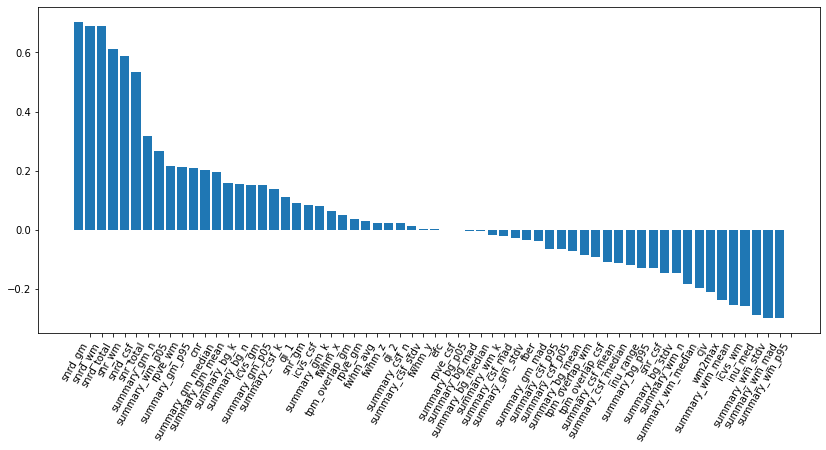


experiment: classes = movement, binary=false, C=0.5, gamma=0.0009765625
acc = 0.8409090909090909; macro f1 = 0.8390804597701149

features ordered by their coeficient (higher first):
['summary_wm_k', 'summary_wm_p95', 'wm2max', 'summary_wm_stdv', 'summary_wm_mad', 'tpm_overlap_wm', 'summary_wm_mean', 'icvs_wm', 'summary_wm_n', 'inu_med', 'summary_gm_stdv', 'snr_csf', 'cjv', 'summary_wm_median', 'summary_gm_mad', 'summary_gm_k', 'tpm_overlap_csf', 'summary_csf_median', 'summary_bg_stdv', 'summary_bg_p95', 'summary_csf_mean', 'tpm_overlap_gm', 'summary_bg_mean', 'inu_range', 'summary_csf_p95', 'summary_csf_p05', 'rpve_csf', 'summary_bg_p05', 'qi_1', 'rpve_gm', 'fwhm_z', 'summary_csf_mad', 'fwhm_x', 'summary_gm_p95', 'summary_csf_n', 'summary_csf_stdv', 'summary_bg_median', 'summary_bg_mad', 'fber', 'fwhm_avg', 'icvs_csf', 'qi_2', 'summary_bg_n', 'icvs_gm', 'summary_gm_median', 'summary_gm_mean', 'fwhm_y', 'rpve_wm', 'efc', 'summary_gm_p05', 'summary_csf_k', 'summary_wm_p05', 'summary_gm_

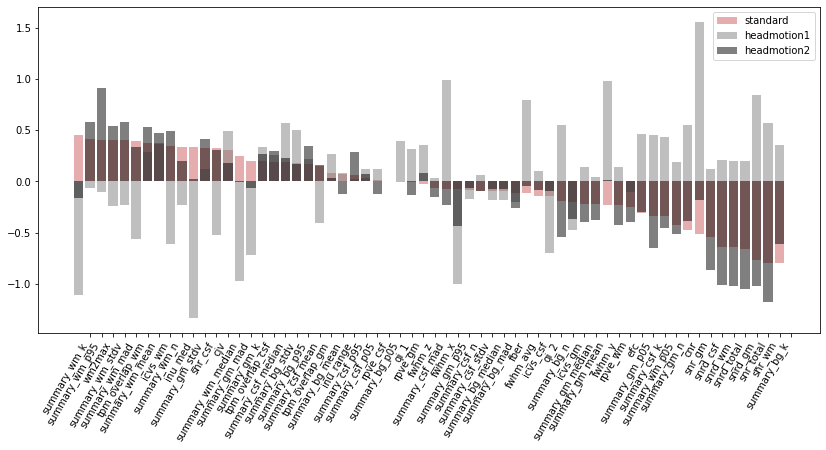

In [ ]:
## feature weights for the linear SVM

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

kernel = 'linear'

for m in maxes[kernel]:
  for s_o in maxes[kernel][m]:
    for is_bin in maxes[kernel][m][s_o]:
      C = maxes[kernel][m][s_o][is_bin]["C"]
      gamma = maxes[kernel][m][s_o][is_bin]["gamma"]

      train_x = vectors[0:N_train]
      train_y = scores[s_o][is_bin][0:N_train]

      test_x = vectors[N_train:]
      test_y = scores[s_o][is_bin][N_train:]

      classif = svm.SVC(kernel=kernel, C=C, gamma=gamma)
      classif.fit(train_x, train_y)
      pred_y = classif.predict(test_x)

      acc = accuracy_score(test_y, pred_y)
      f1 = f1_score(test_y, pred_y, average='macro')

      coefs = classif.coef_

      if len(coefs) == 1:   ## binary classification
        plot_binary_features(coefs[0], cols, s_o, is_bin, C, gamma)
      else:
        plot_multiclass_features(coefs, cols, s_o, is_bin, C, gamma, list(classif.classes_))

